In [1]:
import numpy as np
import numpy.random as rd
import numpy.linalg
import pylab
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes="colorblind")
pylab.rcParams['figure.figsize'] = (30, 25)

rd.seed()

# **INITIALISATION, DEFINITION DES PARAMETRES DU MODELE**

In [2]:
#Définition des paramètres du modèle. Nous avons respecté les notations du cours pour nommer nos différentes variables

tau = np.array([[0, 3, 5, 7, 7],
      [2, 0, 2, 5, 5], 
      [4, 2, 0, 3, 3], 
      [8, 6, 4, 0, 2], 
      [7, 7, 5, 2, 0]]) *60

Lambda = np.array([2.8, 3.7, 5.5, 3.5, 4.6])/3600

p =   np.array([[0, 0.22, 0.32, 0.2, 0.26],
      [0.17, 0, 0.34, 0.21, 0.28], 
      [0.19, 0.26, 0, 0.24, 0.31], 
      [0.17, 0.22, 0.33, 0, 0.28], 
      [0.18, 0.24, 0.35, 0.23, 0]])

# CI

def initialisation():
    nbVelo = np.array([20, 15, 17, 13, 18])

    nbVeloTrajet = np.array([[0, 1, 0, 0, 0],
                          [1, 0, 1, 0, 0], 
                          [0, 1, 0, 1, 0], 
                          [0, 0, 1, 0, 1], 
                          [0, 0, 0, 1, 0]])
    return nbVelo, nbVeloTrajet


lambda_itij=np.zeros((5,5))

for i in range(5):
    for j in range(5):
        lambda_itij[i,j]=Lambda[i]*p[i,j]
        
lambda_tijj=np.zeros((5,5))

for i in range(5):
    for j in range(5):
        if (i==j):
            lambda_tijj[i,j]
        else:
            lambda_tijj[i,j]=1 / tau[i, j]

    


In [4]:
def ChooseNextStep(nbVelo, nbVeloTrajet):
    '''Cette fonction simule les variables aléatoires exponentielles de chacune des positions possibles
    et détermine quel est le prochain évènement à arriver dans notre simulation'''
    departDuneStation = True #Indique si le projet évènement est un départ, ou une arrivée en station
    temps_min=1000000
    
    #Indice i et j du prochain évènement à arriver
    i_min=0 
    j_min=0
    
    x=0 #Variable temporaire représentant la loi exponentielle de chacune des variables
    for i in range(5):
        if nbVelo[i] != 0:
            for j in range(5):
                if(lambda_itij[i,j]!=0):
                    x=np.random.exponential(1/lambda_itij[i,j])
                    if (x <=temps_min and x>0):
                        temps_min=x
                        i_min=i
                        j_min=j

    for i in range(5):
        for j in range(5):    
            if(lambda_tijj[i,j]*nbVeloTrajet[i,j]!=0):
                x=np.random.exponential(1/(lambda_tijj[i,j]*nbVeloTrajet[i,j]))
                if (x <=temps_min and x>0):
                        temps_min=x
                        i_min=i
                        j_min=j
                        departDuneStation=False;
    
    return(departDuneStation, i_min, j_min, temps_min)

def nextStep(nb_Velo,nb_VeloTrajet):
    departDuneStation, i_min, j_min, time = ChooseNextStep(nb_Velo, nb_VeloTrajet)
    if (departDuneStation):
        nb_Velo[i_min] += -1
        nb_VeloTrajet[i_min,j_min] += 1
    else:
        nb_VeloTrajet[i_min,j_min] += -1
        nb_Velo[j_min] += 1
        
    return time
            
                    
def simul(t, nbVelo, nbVeloTrajet): 
    '''Réalise la simulation pour une durée t en secondes'''
    temps=[0]
    nbVeloTab = [[],[],[],[],[]]
    for i in range(5):
        nbVeloTab[i].append(nbVelo[i])
        
    while(temps[-1]<t):
        temps.append(temps[-1]+nextStep(nbVelo,nbVeloTrajet));
        for i in range(5):
            nbVeloTab[i].append(nbVelo[i])
    
    return (nbVeloTab,temps)


# 3)**TRACE DES COURBES, LANCEMENT D'UNE SIMULATION**

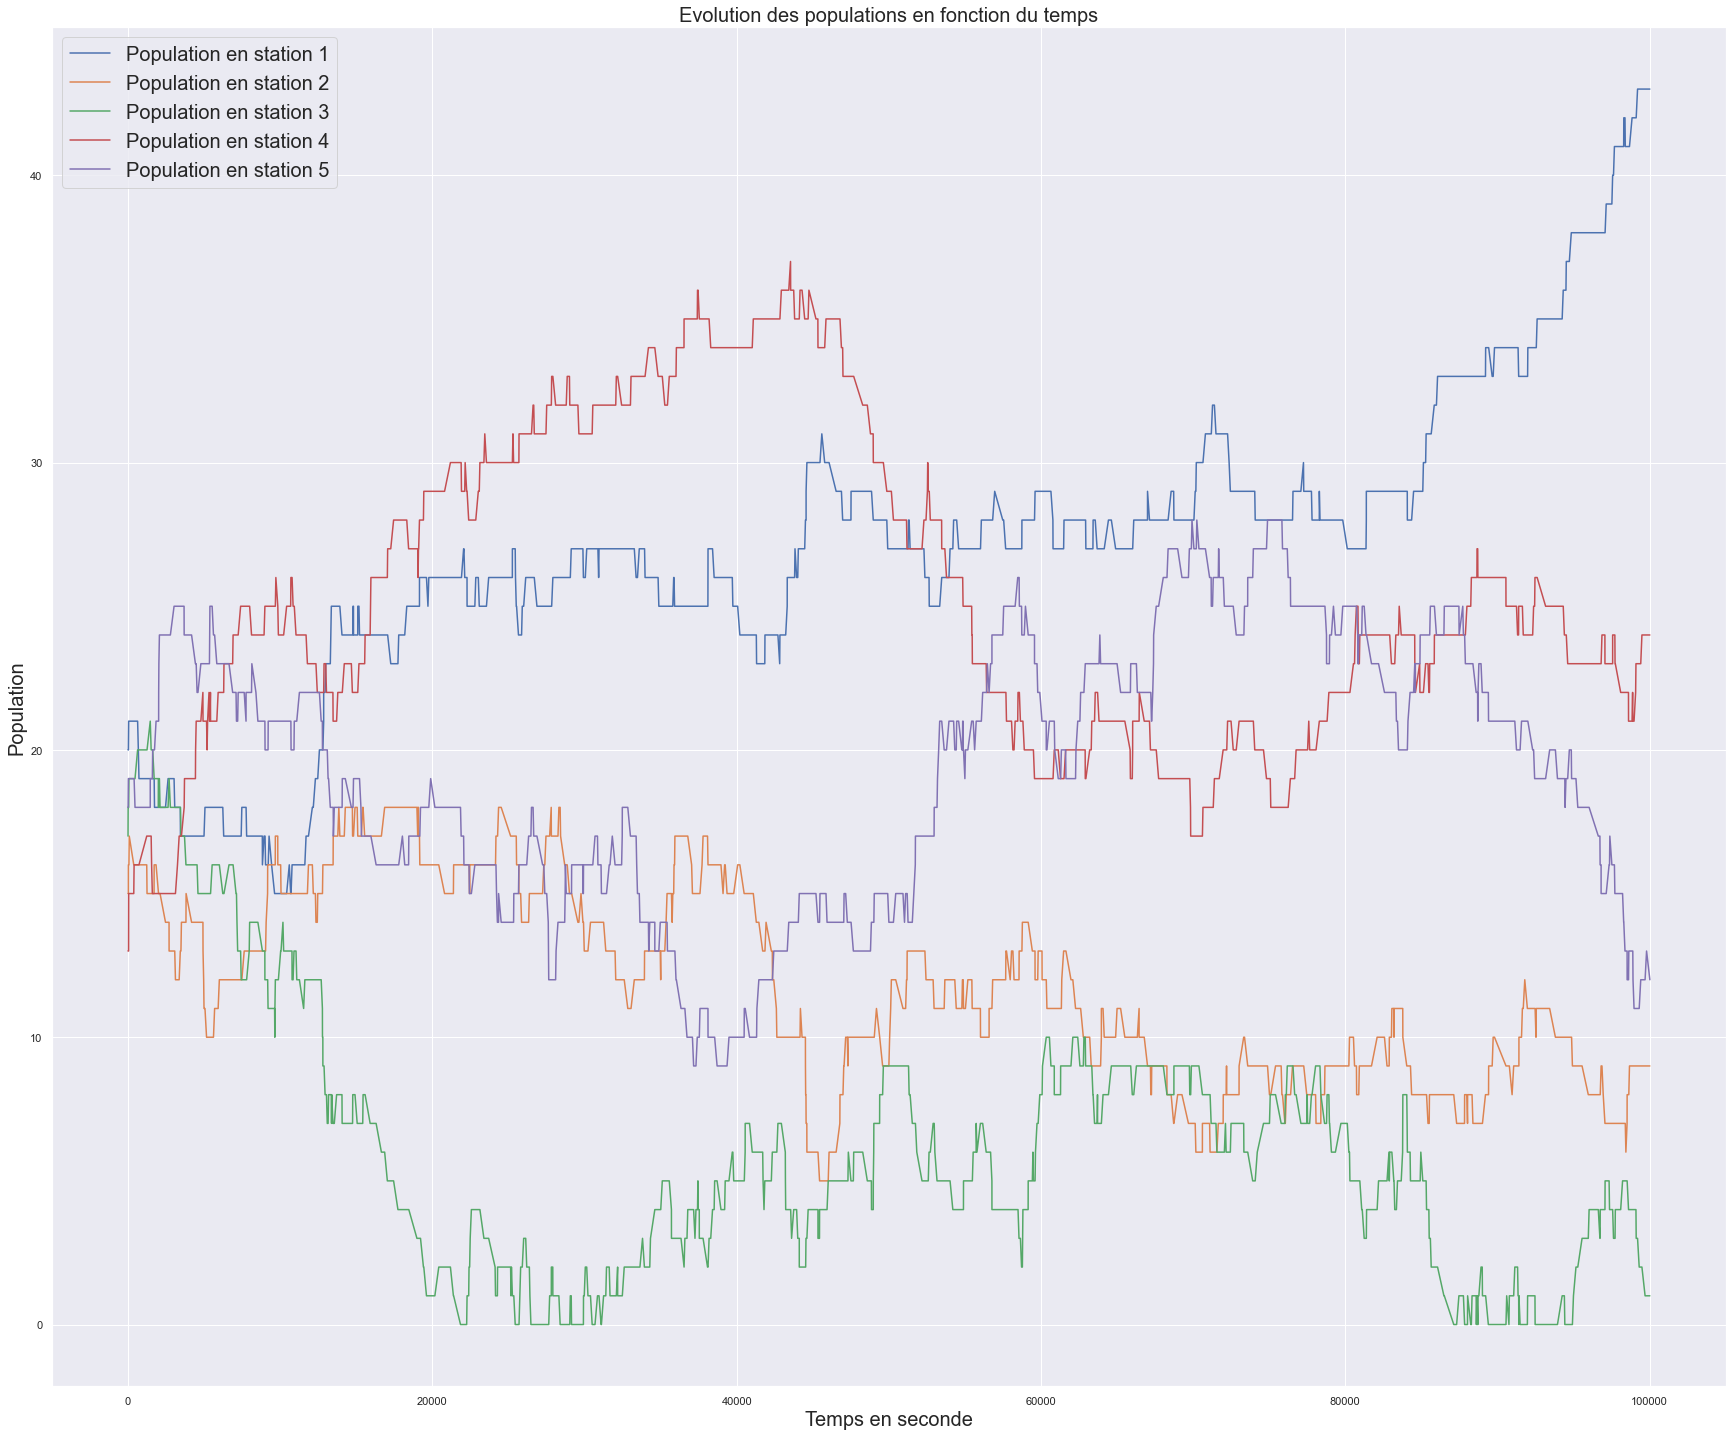

In [5]:
##PLOT MARKOV PROCESSnb
nbVelo, nbVeloTrajet=initialisation()
nbVelo_test,temps_test = simul(100000, nbVelo, nbVeloTrajet)
plt.figure()
plt.clf()
plt.plot(temps_test, nbVelo_test[0], label = "Population en station 1")
plt.plot(temps_test, nbVelo_test[1], label = "Population en station 2")
plt.plot(temps_test, nbVelo_test[2], label = "Population en station 3")
plt.plot(temps_test, nbVelo_test[3], label = "Population en station 4")
plt.plot(temps_test, nbVelo_test[4], label = "Population en station 5")
plt.xlabel("Temps en seconde", fontsize=20)
plt.ylabel("Population", fontsize=20)
plt.title("Evolution des populations en fonction du temps", fontsize=20)
plt.legend(fontsize=20)

# 4) Probabilité empirique que la station soit vide après 150h

On simule le processus de Markov ici sur 150 heures, 500 fois, en regardant l'estimation empirique du nombre de fois ou une station donnée se retrouve vide après un certain temps

In [6]:
def calculProba(n):
    p = np.zeros(5)
    for i in range(n):
        nbVelo, nbVeloTrajet=initialisation()
        nbVeloTab, temps = simul(540000, nbVelo, nbVeloTrajet)

        for j in range(5):
            if nbVeloTab[j][-1]==0:
                p[j]+=1
    p=p/n
    return p
            

In [11]:
p = calculProba(100)

# 5) Estimation de l'intervalle de confiance

On se place dans l'approximation du théorème centrale limite, et on considère que la loi de probabilité qui donne la moyenne du nombre de stations vide suit une loi normale. 



In [27]:
#Première méthode:
n=100
for i in range(5):
    print("L'intervalle de confiance pour la station ",i," est : [" +str(p[i]-1.96*np.sqrt(p[i]*(1-p[i])/n)) + " ; " + 
          str(p[i]+1.96*np.sqrt(p[i]*(1-p[i])/n)) + "]")
    
#Deuxième méthode normalisée par n-1 : 
std = [n/(n-1),n/(n-1),n/(n-1),n/(n-1),n/(n-1)]

for i in range(5):
    std[i] = np.sqrt(std[i]*(p[i]-p[i]**2))

interv = [1.96, 1.96, 1.96, 1.96, 1.96]
for i in range (5):
    interv[i] = interv[i]*std[i]/np.sqrt(n)

print("Les intervalles de confiance avec la deuxieme methode :")

intervals = [[p[x] - epsilon[x], p[x] + epsilon[x]] for x in range (5)]

for i in range(5):
    print("L'intervalle de confiance pour la station ",i," est :",intervals[i])

L'intervalle de confiance pour la station  0  est : [0.0 ; 0.0]
L'intervalle de confiance pour la station  1  est : [0.013452579018811368 ; 0.10654742098118863]
L'intervalle de confiance pour la station  2  est : [0.05630753890765407 ; 0.18369246109234594]
L'intervalle de confiance pour la station  3  est : [0.007282790353301406 ; 0.0927172096466986]
L'intervalle de confiance pour la station  4  est : [0.08814521310309244 ; 0.23185478689690758]
Les intervalles de confiance avec la deuxieme methode :
L'intervalle de confiance pour la station  0  est : [0.0, 0.0]
L'intervalle de confiance pour la station  1  est : [0.01321808171111536, 0.10678191828888464]
L'intervalle de confiance pour la station  2  est : [0.05598666805526628, 0.1840133319447337]
L'intervalle de confiance pour la station  3  est : [0.007067588942712304, 0.0929324110572877]
L'intervalle de confiance pour la station  4  est : [0.08778322196121574, 0.23221677803878427]


# 6) Détermination des relations entre les coefficients de probabilité stationnaire


On rappelle les équations du trafic :

$$\left \{ \begin{array}{l} \sum_{j = 1}^J \alpha_j = 1 \\
\forall j \leq J, \alpha_j \sum_{k = 1}^J \lambda_{jk} = \sum_{k = 1}^J \alpha_k \lambda_{kj} \end{array} \right .$$

Ici les transitions possibles sont les chemins entre chaque station et les trajets allant de chaque station vers elle-même pour représenter le temps d'attente. Ainsi, on peut réécrire les équations du trafic (on ne considère que 5 stations), avec la convention qu'un trajet d'une station vers elle-même représente la station en question (ie $\alpha_i \equiv \alpha_{t_{ii}}, \lambda_i \equiv \lambda_{t_{ii}}$) :

$$\left \{ \begin{array}{l} \sum _{i = 1}^5 \sum_{j = 1}^5 \alpha_{t_{ij}} = 1 \\
\forall i \leq 5, \left \{ \begin{array}{l} \alpha_i \sum_{j = 1, \neq i}^5 \lambda_{i, t_{ij}} = \sum_{j = 1, \neq i}^5 \alpha_{t_{ji}} \lambda_{t_{ji}, i} (1) \\
\forall j \neq i, \alpha_{t_{ij}} \lambda_{t_{ij}, j} = \alpha_i \lambda_{i, t_{ij}} (2) \end{array} \right. \end{array} \right .$$


# 7) Combien d'états y a-t-il dans l'espace d'états s'il n'y a qu'un seul vélo ?

S'il n'y a qu'un seul vélo, l'ensemble des états est totalement décrits par la position actuelle de ce vélo. Il y a donc autant d'états que de de positions possibles pour notre vélo. Il y a ici 5 stations, et 20 trajets possibles, soit un total de 25 états

# 8) Dans le cas où il n'y a qu'un vélo, quels sont les probabilités pour chaque station d'être vide ?

Dans le cas où il n'y a qu'un seul vélo, une station ne peut être que vide, ou occupée. Il faut donc calculer les probabilités stationnaires de chaque station, et on en déduira facilement la probabilité pour une station d'être vide. Reprenons les équations de traffic ci-dessus. 

On a $(2) \Rightarrow \forall j \neq i, \alpha_{t_{ij}} = \alpha_i \frac{\lambda_{i, t_{ij}}}{\lambda_{t_{ij}, j}}$

On utilise cette relation sur le côté droit de l'équation dans $(1)$ (attention, i et j sont inversés) :

$$(1) \Rightarrow \forall i \leq 5, \alpha_i \sum_{j = 1, \neq i}^5 \lambda_{i, t_{ij}} = \sum_{j = 1, \neq i}^5 \alpha_j \lambda_{j, t_{ji}} \\
\Leftrightarrow \forall i \leq 5, \alpha_i \sum_{j = 1, \neq i}^5 \lambda_{i, t_{ij}} - \sum_{j = 1, \neq i}^5 \alpha_j \lambda_{j, t_{ji}} = 0 \\
\Leftrightarrow M\alpha = X$$

Avec : 
$$\alpha = \begin{pmatrix} \alpha_1 \\ ... \\ \alpha_5 \end{pmatrix} \\
M_{ij} = \left \{ \begin{array}{l} \sum_{k = 1, \neq i}^5 \lambda_{i, t_{ik}} \textrm{ si } i = j \\
 - \lambda_{j, t_{ji}} \textrm{ sinon } \end{array} \right .\\
X = 0$$

On remplace la dernière ligne de $M$ par une ligne de 1, et on remplace la dernière valeur de $X$ par un 1 pour être sûr de ne pas avoir une solution nulle. Cette équation permet ainsi d'obtenir les $\alpha_i$ comme solution de $\alpha = M^{-1}X$, et la relation $(2)$ permet de déduire les $\alpha_{t_{i, j}}$. On utilisera plus tard un facteur de normalisation pour respecter la condition de somme à 1 sur tous les $\alpha_i$ et $\alpha_{t_{ij}}$.

Calculons cela informatiquement


In [35]:
X = np.zeros(5)
X[4] = 1

M = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        if i == j:
            M[i, j] = sum([ (lambda_itij[i, k] if i != k else 0) for k in range(5) ])
        else:
            M[i, j] = -lambda_itij[j, i]
M[4,:] = np.ones(5)
alpha = np.dot(np.linalg.inv(M), X)

all_alpha = [ [ alpha[i] if i == j else alpha[i] * lambda_itij[i, j] / lambda_tijj[i, j] for j in range(5) ] for i in range(5) ]

G_N = np.sum(all_alpha)

print("Probabilités théoriques que les stations soient vides :")
print([ 1 - all_alpha[i][i] / G_N for i in range(5) ])

Probabilités théoriques que les stations soient vides :
[0.8321704317214967, 0.8388546706096623, 0.8580139299585932, 0.8385161482338817, 0.8501158888898838]


# 9) Comparaison des résultats à la simulation

In [33]:
#On réalise notre simulation à nouveau, en changeant notre état initial, de manière à ce qu'il n'y ait qu'un seul vélo

def initialisation2():
    nbVelo = np.array([1, 0, 0, 0, 0])

    nbVeloTrajet = np.zeros((5,5))
    return nbVelo, nbVeloTrajet

def calculProba2(n):
    p = np.zeros(5)
    for i in range(n):
        nbVelo, nbVeloTrajet=initialisation2()
        nbVeloTab, temps = simul(540000, nbVelo, nbVeloTrajet)

        for j in range(5):
            if nbVeloTab[j][-1]==0:
                p[j]+=1
    p=p/n
    return p
            


In [34]:
calculProba2(500)

array([0.95 , 0.968, 0.946, 0.954, 0.942])

Ces probas ne sont pas cohérentes avec les équations théoriques trouvées. Nous avons sûrement fait une erreur

# 10) Simulation avec 100 vélos, répartis uniformément

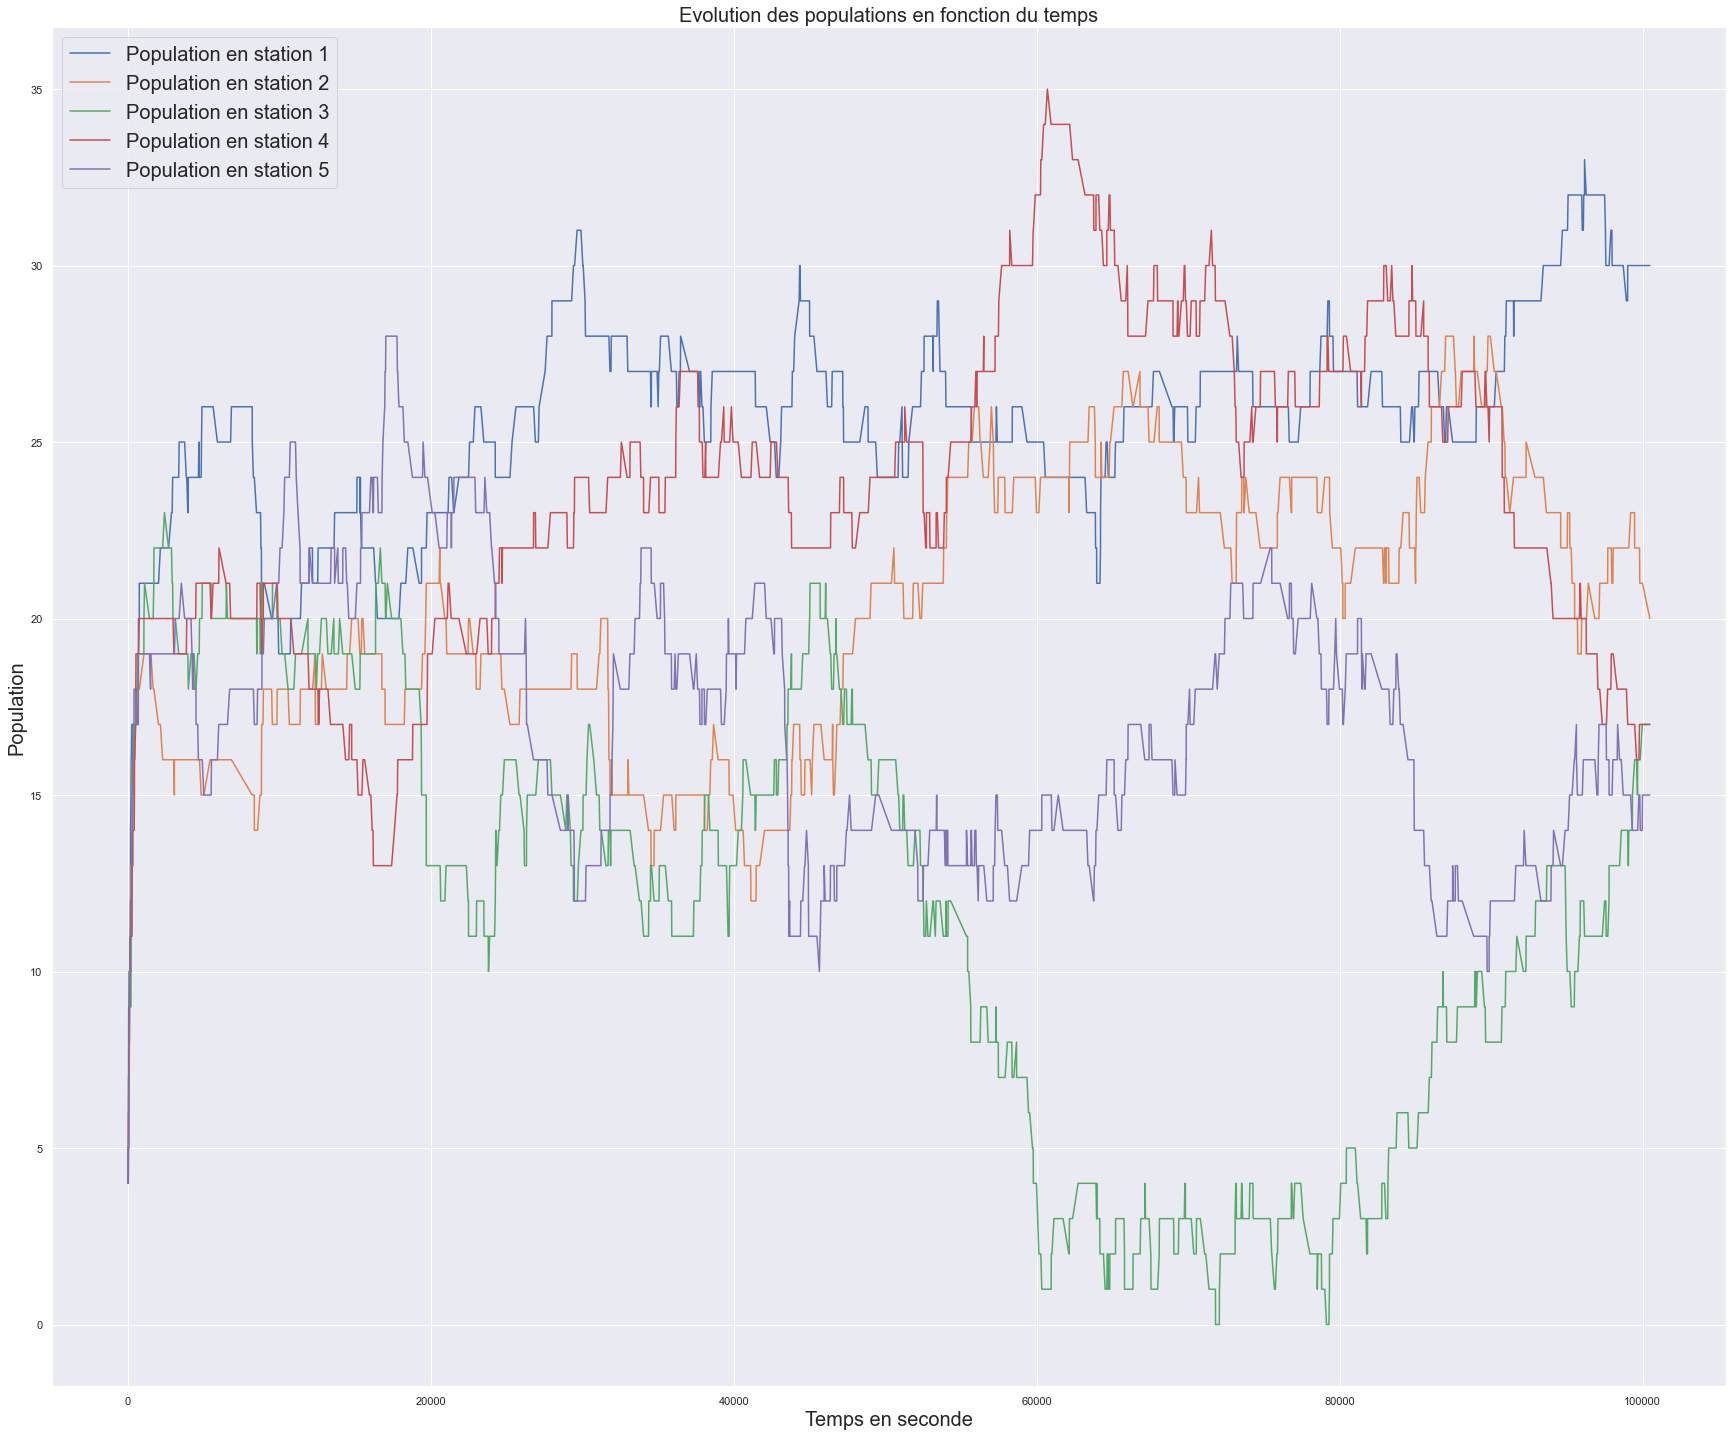

In [36]:
def initialisation3():
    nbVelo = np.array([4, 4, 4, 4, 4])

    nbVeloTrajet = np.ones((5,5))*4
    return nbVelo, nbVeloTrajet

##PLOT MARKOV PROCESSnb
nbVelo, nbVeloTrajet=initialisation3()
nbVelo_test,temps_test = simul(100000, nbVelo, nbVeloTrajet)
plt.figure()
plt.clf()
plt.plot(temps_test, nbVelo_test[0], label = "Population en station 1")
plt.plot(temps_test, nbVelo_test[1], label = "Population en station 2")
plt.plot(temps_test, nbVelo_test[2], label = "Population en station 3")
plt.plot(temps_test, nbVelo_test[3], label = "Population en station 4")
plt.plot(temps_test, nbVelo_test[4], label = "Population en station 5")
plt.xlabel("Temps en seconde", fontsize=20)
plt.ylabel("Population", fontsize=20)
plt.title("Evolution des populations en fonction du temps", fontsize=20)
plt.legend(fontsize=20)

